# Guided Project:  Building A Handwritten Digits Classifier

The goal of this project is to conduct image processing of hand-written numbers using deep neural network.

The dataset is loaded from Scikit-learn library with `load_digits()` function, returning a dataset of [copied hand-written digits from UCI](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits).

## 1. Introduction

We try to explore the dataset using `Axes.imshow()` function which converts a numpy array of pixel values into an image representation.

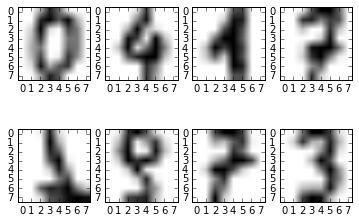

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

digits = load_digits(n_class = 10) # Returning ~1800 samples
df = pd.DataFrame(digits.data)
df["label"] = pd.DataFrame(digits.target)
fig, axes = plt.subplots(2, 4)
sample_rows = [0, 100, 200, 300, 1000, 1100, 1200, 1300]
for i in range(8):
    np_image = df.iloc[sample_rows[i]].drop(labels = "label")
    np_image = np_image.values.reshape(8, 8)
    axes[i//4, i%4].imshow(np_image, cmap = "gray_r")
plt.show()

## 2. Training and Testing with k-Nearest Neighbor Classifier Algorithm

To perform training and testing, we write three pipeline functions. The first function, `train()`, trains using `k`-nearest neighbors models, where we use the default value $k = 5$. The second function, `test()`, tests the model. Finally, the function `cross-validate()` performs `k`-fold validation of the dataset using the two former functions.

We then vary the fold value `k` from 2 to 10 and plot the accuracy scores.

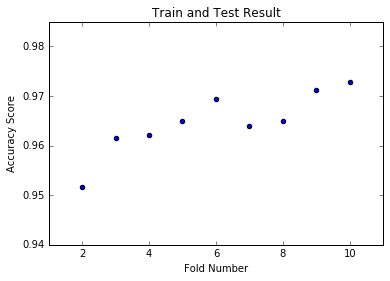

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def train(df, knn):
    knn.fit(df.drop(columns = "label"), df["label"])

def test(df, knn):
    predictions = knn.predict(df.drop(columns = "label"))
    return accuracy_score(predictions, df["label"])

def cross_validate(df, k):
    fold_len = len(df) // k
    knn = KNeighborsClassifier(n_neighbors = 5)
    accuracy_scores = []
    for i in range(k):
        start = i * fold_len
        end = (i+1) * fold_len if i != k-1 else len(df)
        test_df = df[start : end]
        train_df = df.drop(index = test_df.index)
        train(train_df, knn)
        accuracy_scores.append(test(test_df, knn))
    return np.mean(accuracy_scores)

xs = range(2, 11)
ys = [cross_validate(df, k) for k in xs]
plt.scatter(xs, ys)
plt.title("Train and Test Result")
plt.xlabel("Fold Number")
plt.ylabel("Accuracy Score")
plt.show()

The accuracy scores are very high. However, the time and space to run the code seems to be long. This is related to the use of k-nearest neighbors, where comparisons with many training rows need to be made. Furthermore, there is no model representation to debug and explore by kNN.

We will then show the use of neural network instead of kNN to perform machine learning prediction more efficiently.

## 3. Predicting using Neural Network

### a. Single Hidden Layer

We use Multi Layer Perceptron (MLP) as the representation of Neural Network (NN). Notice that the train and test functions are applicable as well to MLP, thus we reuse these functions and instead introduce `nn_cross_validate()` which uses `MLPClassifier` single layer class.

The function will return a 2-tuple of the accuracy score for testing set, followed by the one for training set. This way, we can check which models are overfitting.

Our first trial shows that the gradient descent does not converge before the maximum iteration, and increasing the `max_iter` parameter does not help much. Therefore we change the solver parameter into `lbfgs`.

We then print the results for fold $k = 4$ and for various `neurons`' sizes as $8, 16, 32, 64, 128$.

In [3]:
from sklearn.neural_network import MLPClassifier

def nn_cross_validate(df, k, neurons):
    fold_len = len(df) // k
    mlp = MLPClassifier(hidden_layer_sizes = neurons,
                        solver = "lbfgs")
    test_accuracy_scores = []
    train_accuracy_scores = []
    for i in range(k):
        start = i * fold_len
        end = (i+1) * fold_len if i != k-1 else len(df)
        test_df = df[start : end]
        train_df = df.drop(index = test_df.index)
        train(train_df, mlp)
        test_accuracy_scores.append(test(test_df, mlp))
        train_accuracy_scores.append(test(train_df, mlp))
    return (np.mean(test_accuracy_scores), np.mean(train_accuracy_scores))

neurons_params = [8, 16, 32, 64, 128]
for n in neurons_params:
    acc_scores = nn_cross_validate(df, 4, n)
    print("n = ", n)
    print("Accuracy score: ", acc_scores)
    print("Average score: ", np.mean(acc_scores), "\n")

n =  8
Accuracy score:  (0.6811172976985894, 0.7642353928611553)
Average score:  0.7226763452798723 

n =  16
Accuracy score:  (0.8820601336302895, 0.996102587572339)
Average score:  0.9390813606013142 

n =  32
Accuracy score:  (0.9343405097748081, 1.0)
Average score:  0.967170254887404 

n =  64
Accuracy score:  (0.9415788171244741, 1.0)
Average score:  0.970789408562237 

n =  128
Accuracy score:  (0.940463994060876, 1.0)
Average score:  0.970231997030438 



The overall accuracies increase in general as the number of neurons `n` are increased. However, as `n` rises (starting from $n = 32$), the model starts to overfit the training data, where it predicts the training set by $100%$ accuracy.

Models that overfit tend to perform worse on the test set, but the result seems to suggests otherwise. It is still possible that the effect shows for larger `n`. Another observation is that when `n` is greater than `32`, the running time starts to be significantly slower than the previous kNN's version. This might be improved by setting appropriate parameters on `MLPClassifier` class.

### b. Double & Triple Hidden Layers

We define two other `nn_cross_validate()`-like functions that takes additional inputs of the second layer and third layer neuron sizes.

In [8]:
def nn_2_cross_validate(df, k, neurons_1, neurons_2):
    return nn_cross_validate(df, k, (neurons_1, neurons_2))

print(nn_2_cross_validate(df, 4, 8, 8))
print(nn_2_cross_validate(df, 4, 16, 16))
print(nn_2_cross_validate(df, 4, 32, 32))

(0.7896015837663944, 0.8653560830860534)
(0.9193256619648602, 1.0)
(0.9131984657263054, 1.0)


In [6]:
def nn_3_cross_validate(df, k, neurons_1, neurons_2, neurons_3):
    return nn_cross_validate(df, k, (neurons_1, neurons_2, neurons_3))

print(nn_3_cross_validate(df, 6, 10, 10, 10))
print(nn_3_cross_validate(df, 6, 20, 20, 20))
print(nn_3_cross_validate(df, 6, 30, 30, 30))

(0.756748026903512, 0.8358914077930738)
(0.9138002318249944, 1.0)
(0.9288005640582663, 1.0)


The trend is still similar to the single layer NN: the performance is better for models with larger `n` increases but the tendency to overfit also increases.

## 4. Conclusion

Lalala

Further improvement might be comparing NN models based on the number of layers.